100%|██████████| 26.4M/26.4M [00:02<00:00, 11.5MB/s]


Extracting ./data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 29.5k/29.5k [00:00<00:00, 198kB/s]


Extracting ./data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 4.42M/4.42M [00:01<00:00, 3.64MB/s]


Extracting ./data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 5.15k/5.15k [00:00<00:00, 11.8MB/s]


Extracting ./data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw

Epoch [1/20], Loss: 514.7683
Epoch [2/20], Loss: 495.5984
Epoch [3/20], Loss: 488.3002
Epoch [4/20], Loss: 485.5980
Epoch [5/20], Loss: 484.4089
Epoch [6/20], Loss: 483.7598
Epoch [7/20], Loss: 483.2484
Epoch [8/20], Loss: 482.7917
Epoch [9/20], Loss: 482.4548
Epoch [10/20], Loss: 482.1889
Epoch [11/20], Loss: 481.9893
Epoch [12/20], Loss: 481.7673
Epoch [13/20], Loss: 481.5919
Epoch [14/20], Loss: 481.4238
Epoch [15/20], Loss: 481.2815
Epoch [16/20], Loss: 481.0524
Epoch [17/20], Loss: 480.8249
Epoch [18/20], Loss: 480.6553
Epoch [19/20], Loss: 480.4136
Epoch [20/20], Loss: 480.2047


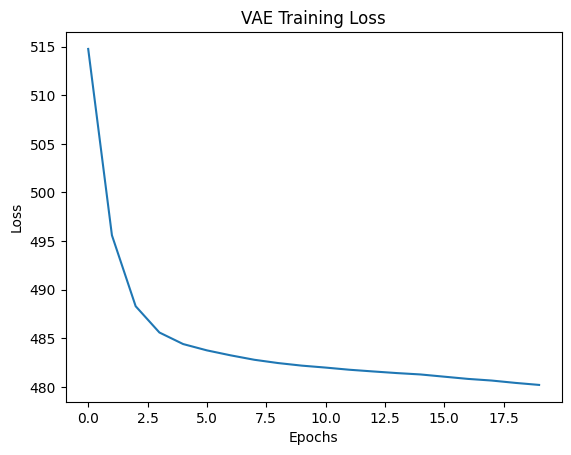

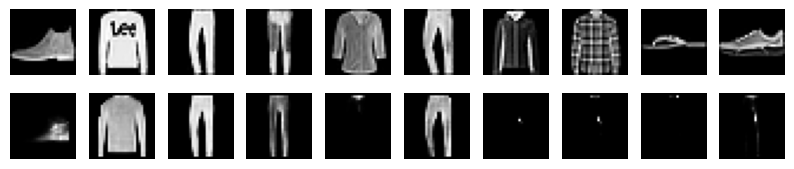

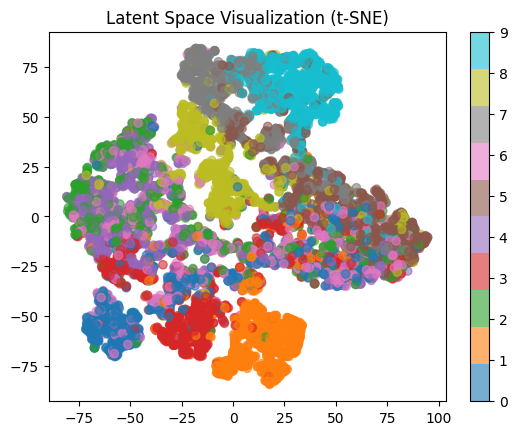

In [1]:
# -*- coding: utf-8 -*-
"""GenAiTutorial3.ipynb

Automatically generated by Colab.

Original file is located at
    https://colab.research.google.com/drive/1rfhtj0IVRj9OYzB63ozWsyzp8fc6Zxmo
"""

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
from sklearn.manifold import TSNE

# Hyperparameters
batch_size = 128
latent_dim = 50
learning_rate = 1e-3
epochs = 20

# Data loading and preprocessing
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
train_dataset = datasets.FashionMNIST(root='./data', train=True, transform=transform, download=True)
test_dataset = datasets.FashionMNIST(root='./data', train=False, transform=transform, download=True)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Define the VAE model
class VAE(nn.Module):
    def __init__(self, latent_dim):
        super(VAE, self).__init__()
        self.encoder = nn.Sequential(
            nn.Flatten(),
            nn.Linear(28 * 28, 512),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.ReLU()
        )
        self.fc_mu = nn.Linear(256, latent_dim)
        self.fc_logvar = nn.Linear(256, latent_dim)
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 256),
            nn.ReLU(),
            nn.Linear(256, 512),
            nn.ReLU(),
            nn.Linear(512, 28 * 28),
            nn.Sigmoid()
        )

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, x):
        hidden = self.encoder(x)
        mu, logvar = self.fc_mu(hidden), self.fc_logvar(hidden)
        z = self.reparameterize(mu, logvar)
        reconstructed = self.decoder(z)
        return reconstructed, mu, logvar

# Define the loss function
def loss_function(recon_x, x, mu, logvar):
    recon_loss = nn.functional.mse_loss(recon_x, x.view(-1, 28 * 28), reduction='sum')
    kl_div = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return recon_loss + kl_div

# Training loop
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = VAE(latent_dim).to(device)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

train_losses = []

for epoch in range(epochs):
    model.train()
    total_loss = 0
    for images, _ in train_loader:
        images = images.to(device).view(-1, 28 * 28)
        optimizer.zero_grad()
        recon, mu, logvar = model(images)
        loss = loss_function(recon, images, mu, logvar)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    avg_loss = total_loss / len(train_loader.dataset)
    train_losses.append(avg_loss)
    print(f"Epoch [{epoch+1}/{epochs}], Loss: {avg_loss:.4f}")

# Loss plot
plt.plot(train_losses)
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("VAE Training Loss")
plt.show()

# Reconstruction test images
model.eval()
with torch.no_grad():
    images, _ = next(iter(test_loader))
    images = images.to(device).view(-1, 28 * 28)
    recon, _, _ = model(images)
    images = images.cpu().view(-1, 1, 28, 28)
    recon = recon.cpu().view(-1, 1, 28, 28)

    fig, axes = plt.subplots(2, 10, figsize=(10, 2))
    for i in range(10):
        axes[0, i].imshow(images[i].squeeze(), cmap='gray')
        axes[0, i].axis('off')
        axes[1, i].imshow(recon[i].squeeze(), cmap='gray')
        axes[1, i].axis('off')
    plt.show()

# Latent space visualization using t-SNE
model.eval()
features, labels = [], []
with torch.no_grad():
    for images, label in test_loader:
        images = images.to(device).view(-1, 28 * 28)
        _, mu, _ = model(images)
        features.append(mu.cpu().numpy())
        labels.append(label.numpy())
features = np.concatenate(features)
labels = np.concatenate(labels)
tsne = TSNE(n_components=2)
latent_2d = tsne.fit_transform(features)
plt.scatter(latent_2d[:, 0], latent_2d[:, 1], c=labels, cmap='tab10', alpha=0.6)
plt.colorbar()
plt.title("Latent Space Visualization (t-SNE)")
plt.show()